### Importing libraries and variable definitions

In [2]:
### Import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import joblib

In [6]:
# Load the data
data = pd.read_pickle("../data/BRFSS2022_modeling_data.pkl")
# data.head()

### Prepping up data: Train-Test split and Oversampling / Undersampling

In [7]:
# Train-test split
X = data.drop(columns=["CVDINFR4"])
y = data["CVDINFR4"]

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42
)

param_grid = [
{'solver' : ['saga'], 'penalty' : ['elasticnet', 'l1', 'l2', 'none'], 'max_iter' : [50,100,200,500,1000,2500], 'C' : [0.001, 0.01, 0.1, 1, 10, 100]},
{'solver' : ['newton-cg', 'lbfgs', 'liblinear'], 'penalty' : ['l2'], 'max_iter' : [50,100,200,500,1000,2500], 'C' : [0.001, 0.01, 0.1, 1, 10, 100]}
]


In [8]:
# Balance the training data using SMOTEENN, SMOTE and Under-sampling
sme = SMOTEENN(random_state=42, enn=EditedNearestNeighbours(sampling_strategy="all")) 
sm = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_smoteenn, y_train_smoteenn = sme.fit_resample(X_train_raw, y_train_raw)
X_train_smote, y_train_smote = sm.fit_resample(X_train_raw, y_train_raw)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train_raw, y_train_raw)

In [114]:
# Keep only 10% of the training data for to check the model execution and performance
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_undersample, y_train_undersample, test_size=0.5, random_state=42
)

In [115]:
# Define scaler to scale the data
scaler = StandardScaler()

In [116]:
# Scale Training and Testing Data. Fit transform separately to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train_sample)
X_test_scaled = scaler.fit_transform(X_test_raw)

In [117]:
# Assigning Train and Test data
X_train = X_train_scaled
y_train = y_train_sample
X_test = X_test_scaled
y_test = y_test_raw

In [118]:
# Checking the shape of the data
print(f"Train Shape={X_train.shape} \tTest shape={X_test.shape} \
      \n1s in train={y_train.sum():,}, \t%1s in train={y_train.sum() / len(y_train):0.1%} \
       \n1s in test={y_test.sum():,}, \t%1s in test={y_test.sum() / len(y_test):0.1%}")

Train Shape=(8182, 68) 	Test shape=(37781, 68)       
1s in train=4,076, 	%1s in train=49.8%        
1s in test=1,944, 	%1s in test=5.1%


## Modeling

### Logistic Regression

Fitting 2 folds for each of 19 candidates, totalling 38 fits
Best parameters found:  {'C': 0.1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0       0.99      0.58      0.73     35837
           1       0.11      0.94      0.19      1944

    accuracy                           0.60     37781
   macro avg       0.55      0.76      0.46     37781
weighted avg       0.95      0.60      0.70     37781

Confusion matrix:
[[20735 15102]
 [  123  1821]]
Accuracy: 0.5970196659696673
Precision: 0.10760503456833895
Recall: 0.9367283950617284


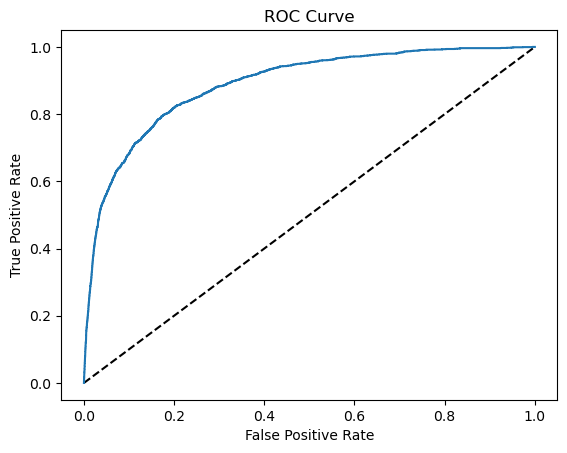

AUC: 0.8886085414630556


In [119]:
# Create the parameter grid based on the results of random search
param_grid = [
    {"solver": ["liblinear"], "penalty": ["l1"], "C": [1e-6], "max_iter": [int(1e6)]},
    {
        "solver": ["newton-cg", "lbfgs", "liblinear"],
        "penalty": ["l2"],
        "max_iter": [50, 100],
        "C": [0.01, 0.1, 1],
    },
]

# Create a base model
clf_logistic = LogisticRegression()

# Create a custom scoring function for precision
precision_scorer = make_scorer(precision_score)

# Instantiate the grid search model with precision as the scoring function
grid_search = GridSearchCV(
    estimator=clf_logistic,
    param_grid=param_grid,
    scoring=precision_scorer,
    cv=2,
    n_jobs=-1,
    verbose=5,
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

# Predict the test set using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# AUC
print("AUC:", roc_auc_score(y_test, y_pred_prob))



Best estimator:LogisticRegression(C=0.1, max_iter=50, solver='newton-cg')


Best parameters:{'C': 0.1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}


Best score:0.8285198252688173


Best index:7


Best average score:[0.         0.82746026 0.82746026 0.82748812 0.82746026 0.82746026
 0.82748812 0.82851983 0.82851983 0.82843211 0.82851983 0.82851983
 0.82843211 0.82780662 0.82780662 0.82802897 0.82780662 0.82780662
 0.82802897]


Best results:{'mean_fit_time': array([0.02050877, 0.12255478, 0.02146339, 0.12521756, 0.12716484,
       0.0299958 , 0.1591959 , 0.14202738, 0.03644681, 0.27208447,
       0.19134331, 0.039325  , 0.24012339, 0.18062949, 0.08345127,
       0.22012532, 0.25558865, 0.06193066, 0.2087481 ]), 'std_fit_time': array([0.00882149, 0.01421309, 0.00977612, 0.0178746 , 0.02459574,
       0.01084149, 0.00157571, 0.00708151, 0.0002625 , 0.07745266,
       0.03548551, 0.00067425, 0.06471765, 0.04723334, 0.04492569,
       0.06072748, 0.0302695 , 0.01249337, 0.0064

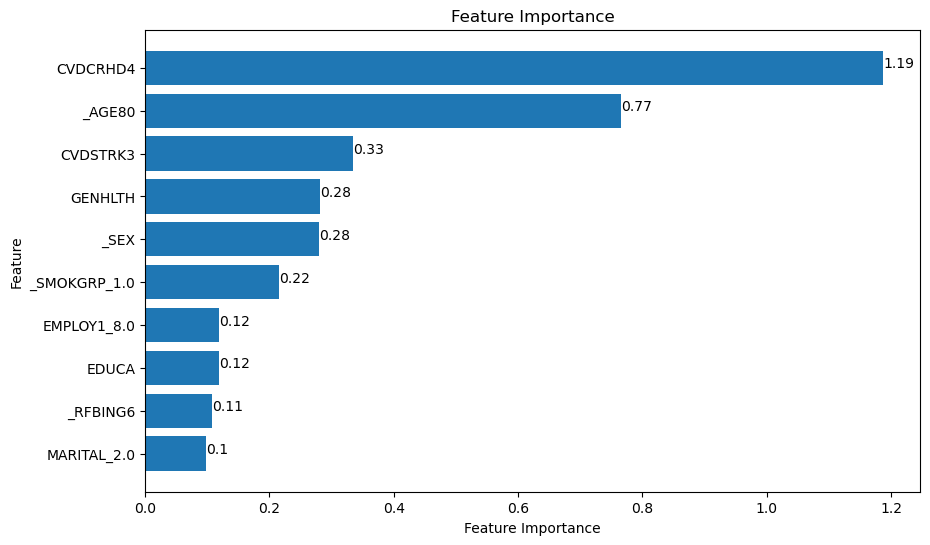

In [120]:
# Print the best model
print(f"\n\nBest estimator:{grid_search.best_estimator_}")

# Print the best parameters
print(f"\n\nBest parameters:{grid_search.best_params_}")

# Print the best score
print(f"\n\nBest score:{grid_search.best_score_}")

# Print the best index
print(f"\n\nBest index:{grid_search.best_index_}")

# Print average score
print(f"\n\nBest average score:{grid_search.cv_results_['mean_test_score']}")

# Print the results
print(f"\n\nBest results:{grid_search.cv_results_}")

# Count the number of features with negative coefficients
negative_coefficients = sum(grid_search.best_estimator_.coef_[0] < 0)
print(f"\n\nNumber of features with negative coefficients: {negative_coefficients}")

# Plot feature importance
feature_importance = dict(zip(X.columns, np.abs(grid_search.best_estimator_.coef_[0])))
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=False)
print ("\n\nFeature importance:")
for feature in sorted_features:
    print(feature)

# Plot feature importance with feature importance values as data labels
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_features[-10:]],
    [x[1] for x in sorted_features[-10:]],
)
for index, value in enumerate([x[1] for x in sorted_features[-10:]]):
    plt.text(value, index, str(round(value, 2)))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()


In [ ]:
# Save the model
# joblib.dump(logistic, '../models/logistic_regression_model.pkl')

# Save the test set
# X_test.to_pickle('../data/logistic_regression_test_set.pkl')
# y_test.to_pickle('../data/logistic_regression_test_labels.pkl')

# Save the ROC curve
# roc_curve_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
# roc_curve_data.to_pickle('../data/logistic_regression_roc_curve.pkl')

# Save the classification report
# classification_report_data = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
# classification_report_data.to_pickle('../data/logistic_regression_classification_report.pkl')

# Save the confusion matrix
# confusion_matrix_data = pd.DataFrame(confusion_matrix(y_test, y_pred))

# confusion_matrix_data.to_pickle('../data/logistic_regression_confusion_matrix.pkl')

# Save the AUC
# auc_data = pd.DataFrame({'AUC': [roc_auc_score(y_test, y_pred_prob)]})
# auc_data.to_pickle('../data/logistic_regression_auc.pkl')

# Save the hyperparameters
# hyperparameters = pd.DataFrame({'C': [grid_search.best_params_['C']], 'penalty': [grid_search.best_params_['penalty']]})
# hyperparameters.to_pickle('../data/logistic_regression_hyperparameters.pkl')

# Save the feature importance
# feature_importance = pd.DataFrame({'feature': X.columns, 'importance': logistic.coef_[0]})
# feature_importance.to_pickle('../data/logistic_regression_feature_importance.pkl')

# Save the model coefficients
# model_coefficients = pd.DataFrame({'feature': X.columns, 'coefficient': logistic.coef_[0]})
# model_coefficients.to_pickle('../data/logistic_regression_model_coefficients.pkl')

# Save the model intercept
# model_intercept = pd.DataFrame({'intercept': logistic.intercept_})
# model_intercept.to_pickle('../data/logistic_regression_model_intercept.pkl')

### Random Forest

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
RandomForestClassifier(max_depth=50, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200)
0.8077491888973843
0
[0.80774919 0.80518227 0.80408216 0.80432694 0.80506003 0.80506021
 0.80640465 0.80334911 0.80567138 0.80750445 0.80652698 0.80261597
 0.80774896 0.80652689 0.80579357 0.80518262 0.80762682 0.8065268
 0.80567129 0.80652667]
{'mean_fit_time': array([ 1.28237597,  5.91002981,  5.49527828, 10.82817817,  8.31764619,
        4.00662271, 19.22405322,  1.36809587,  7.34209879, 13.79346983,
        3.4730715 , 10.23559769,  9.06911294, 13.12384717, 16.71516458,
        9.56932362,  8.0350457 ,  4.68196988, 15.11222156,  8.97532145]), 'std_fit_time': array([0.06189583, 0.56153722, 0.41348649, 0.15732364, 0.29037543,
       0.17952036, 0.24704773, 0.06238224, 0.10673113

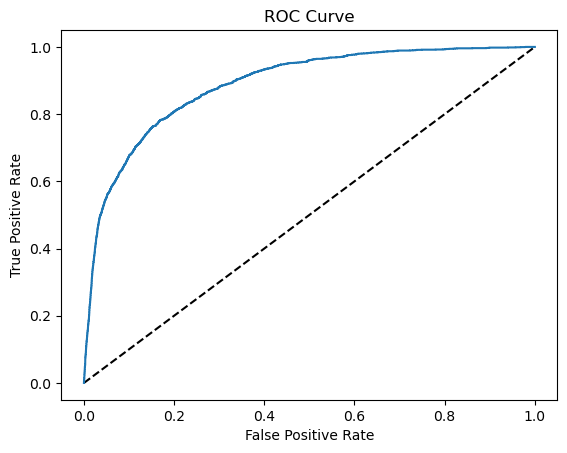

AUC: 0.8875849023085893


In [129]:
# Perform random search for hyperparameter tuning using random forest classifier
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ["log2", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf_random_forest = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(
    estimator=clf_random_forest,
    param_distributions=random_grid,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
# Fit the random search model
clf_random.fit(X_train, y_train)

# Print the best parameters
print(clf_random.best_params_)
# Print the best model
print(clf_random.best_estimator_)
# Print the best score
print(clf_random.best_score_)
# Print the best index
print(clf_random.best_index_)
# Print average score
print(clf_random.cv_results_["mean_test_score"])
# Print the results
print(clf_random.cv_results_)
# Print feature importance
feature_importance = dict(
    zip(X.columns, clf_random.best_estimator_.feature_importances_)
)
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature in sorted_features:
    print(feature)

# Predict the test set using the best model
y_pred = clf_random.best_estimator_.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = clf_random.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# AUC
print("AUC:", roc_auc_score(y_test, y_pred_prob))

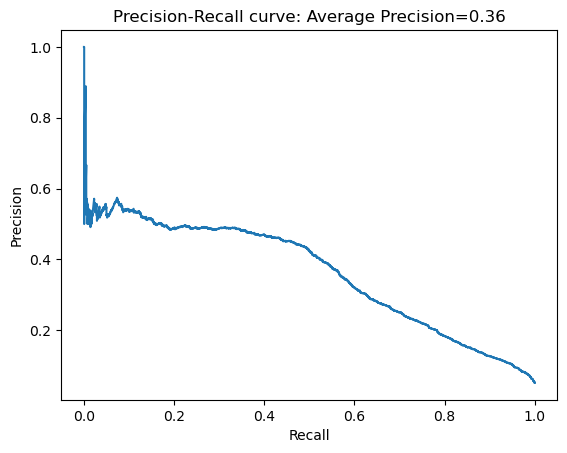

In [182]:
# Plot PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)
# Show the average precision in the plot

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(
    f"Precision-Recall curve: Average Precision={average_precision:0.2f}"
)
plt.show()

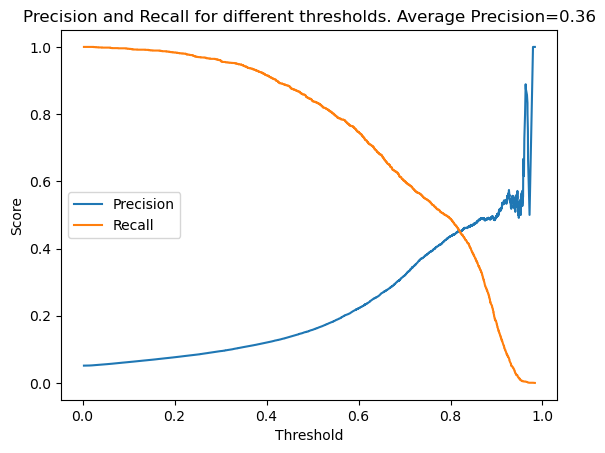

In [181]:
# Plot Precision and Recall for different thresholds
plt.plot(thresholds, precision[1:], label="Precision")
plt.plot(thresholds, recall[1:], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title(f"Precision and Recall for different thresholds. Average Precision={average_precision:0.2f}")
plt.show()

In [178]:
# Print precision and recall for different thresholds
threshold_values = np.linspace(0, 1, 11)
for threshold in threshold_values:
    if threshold > thresholds.max():
        threshold = np.round(thresholds.max(),2)
    else:
        threshold=np.round(threshold, 2)
    precision_threshold = precision[np.where(thresholds >= threshold)[0][0]]
    recall_threshold = recall[np.where(thresholds >= threshold)[0][0]]
    print(
        f"Threshold: {threshold}, Precision: {precision_threshold}, Recall: {recall_threshold}"
    )

Threshold: 0.0, Precision: 0.05145443476879913, Recall: 1.0
Threshold: 0.1, Precision: 0.0620227170634666, Recall: 0.9943415637860082
Threshold: 0.2, Precision: 0.07646470705858828, Recall: 0.9835390946502057
Threshold: 0.3, Precision: 0.0946940847930947, Recall: 0.9593621399176955
Threshold: 0.4, Precision: 0.12007289416846652, Recall: 0.9151234567901234
Threshold: 0.5, Precision: 0.15804263565891472, Recall: 0.8389917695473251
Threshold: 0.6, Precision: 0.22179761540813206, Recall: 0.7463991769547325
Threshold: 0.7, Precision: 0.3196496989600438, Recall: 0.6008230452674898
Threshold: 0.8, Precision: 0.4367816091954023, Recall: 0.4886831275720165
Threshold: 0.9, Precision: 0.49356223175965663, Recall: 0.17746913580246915
Threshold: 0.98, Precision: 1.0, Recall: 0.00051440329218107


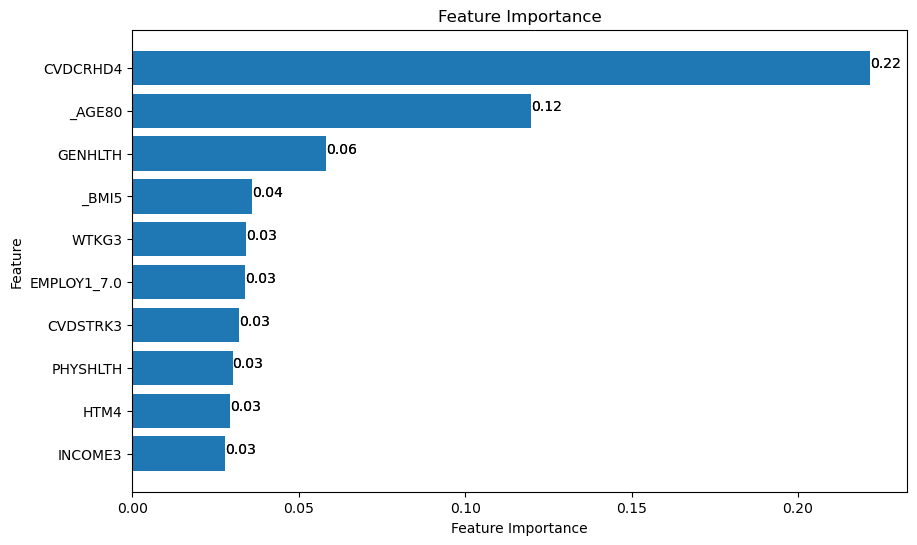

In [136]:
# Feature importance plot with feature importance values as data labels
sorted_features_reverse = sorted(feature_importance.items(), key=lambda x: x[1], reverse=False)
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_features_reverse[-10:]],
    [x[1] for x in sorted_features_reverse[-10:]],
)

for index, value in enumerate([x[1] for x in sorted_features_reverse[-10:]]):
    plt.text(value, index, str(round(value, 2)))

# Add feature imporatance values ad data labels to the plot
for index, value in enumerate([x[1] for x in sorted_features_reverse[-10:]]):
    plt.text(value, index, str(round(value, 2)))



plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

In [132]:
clf_random.cv_results_

{'mean_fit_time': array([ 1.28237597,  5.91002981,  5.49527828, 10.82817817,  8.31764619,
         4.00662271, 19.22405322,  1.36809587,  7.34209879, 13.79346983,
         3.4730715 , 10.23559769,  9.06911294, 13.12384717, 16.71516458,
         9.56932362,  8.0350457 ,  4.68196988, 15.11222156,  8.97532145]),
 'std_fit_time': array([0.06189583, 0.56153722, 0.41348649, 0.15732364, 0.29037543,
        0.17952036, 0.24704773, 0.06238224, 0.10673113, 0.49448651,
        0.14048271, 0.40344106, 0.26543435, 0.47961985, 0.24970167,
        0.40316267, 0.17526363, 0.11893334, 0.13632216, 0.07579137]),
 'mean_score_time': array([0.08730427, 0.3049825 , 0.38944642, 0.8570315 , 0.84427198,
        0.22636   , 1.33987888, 0.08425093, 0.61042595, 1.30029869,
        0.21528252, 0.62901664, 0.63917383, 0.74957403, 1.06696812,
        0.82484285, 0.52333458, 0.38416012, 0.88249795, 0.67563462]),
 'std_score_time': array([0.00370973, 0.01829661, 0.05400421, 0.07932372, 0.17535724,
        0.0392975 , 

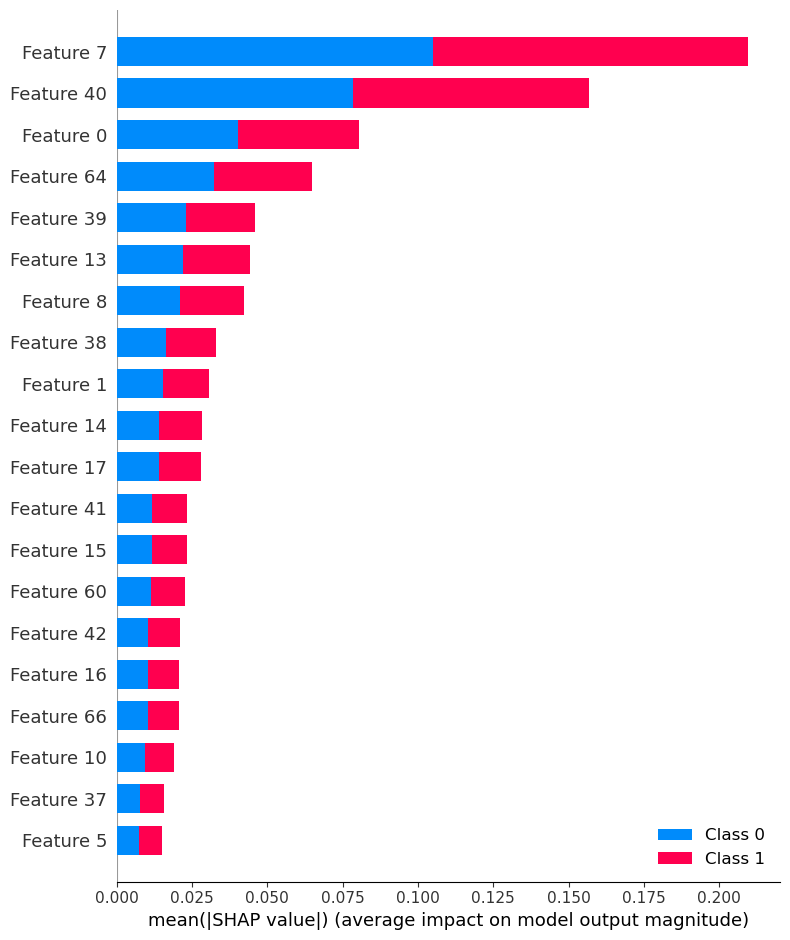

In [185]:
# Shapley analysis with values and plot
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf_random.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

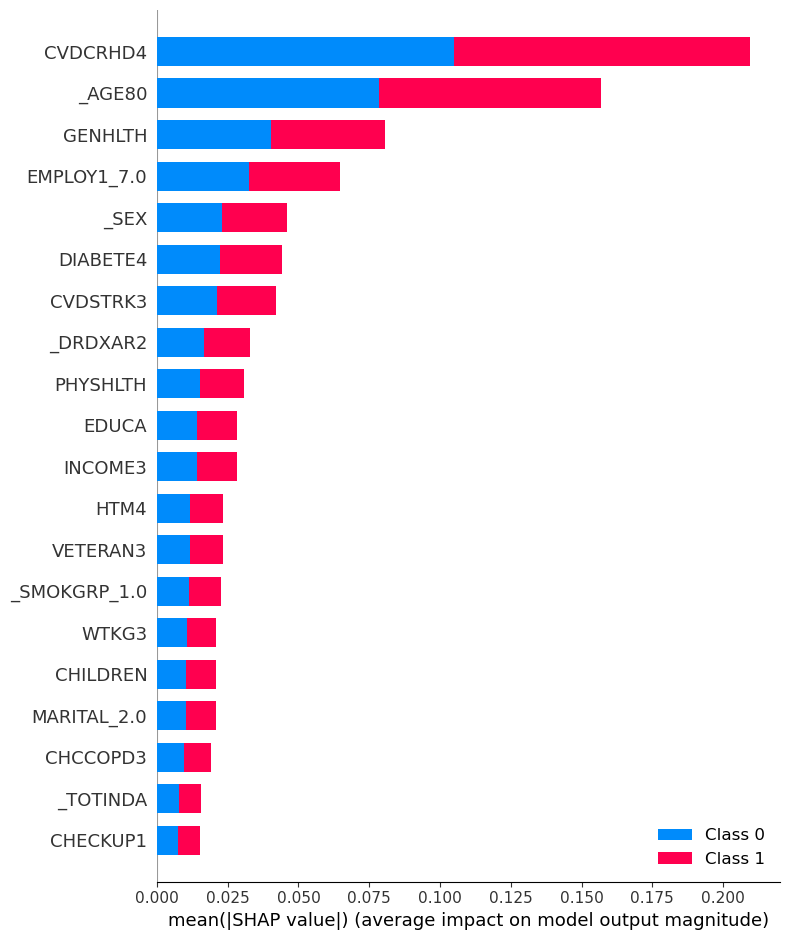

In [189]:
# Shapley plot with feature names and values as data labels
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")


Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


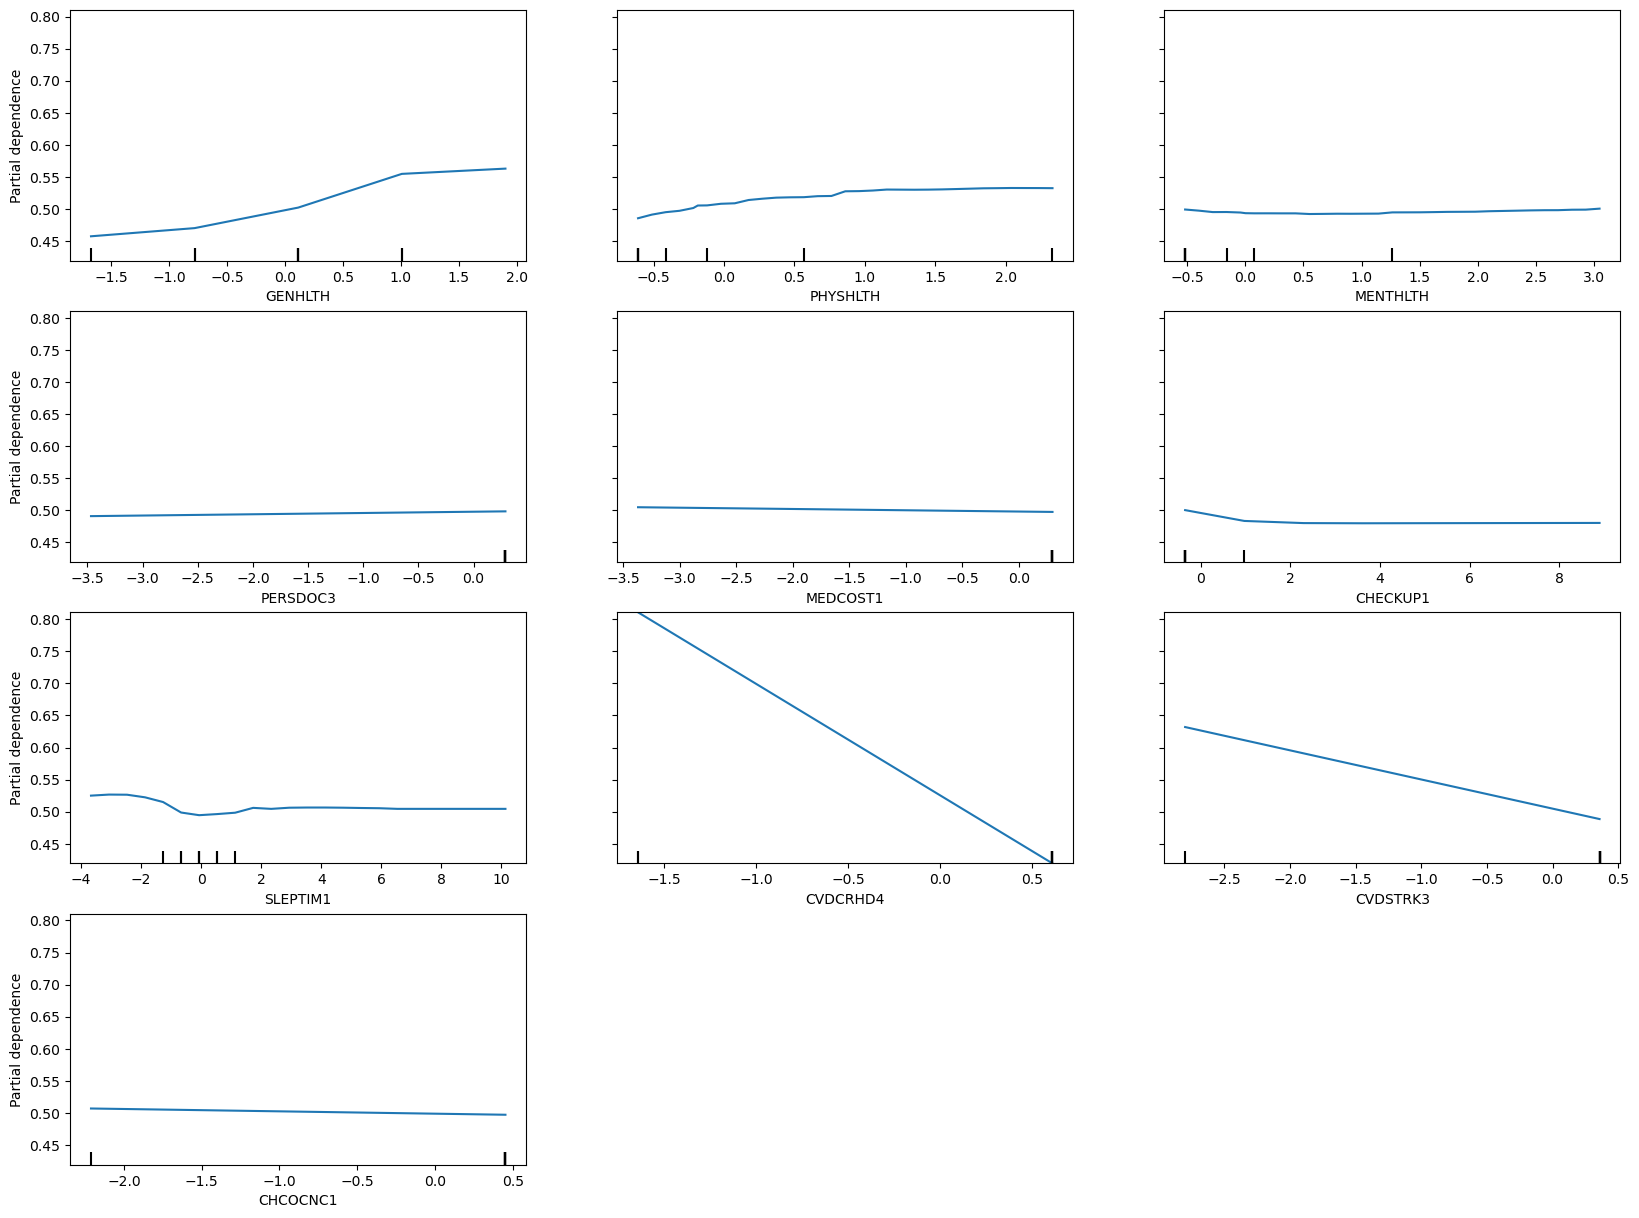

In [212]:
# Partial dependence plot
from sklearn.inspection import plot_partial_dependence

# Set figure size
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Plot partial dependence on figure
plot_partial_dependence(clf_random.best_estimator_, X_train, features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], feature_names=X.columns, grid_resolution=50, ax=ax)
plt.show()

### XGBoost

In [ ]:
# Create an XGBClassifier

from xgboost import XGBClassifier

# Create a base model
clf_xgb = XGBClassifier()

# Create a custom scoring function for precision
precision_scorer = make_scorer(precision_score)

# Instantiate the grid search model with precision as the scoring function
grid_search = GridSearchCV(
    estimator=clf_xgb,
    param_grid=param_grid,
    scoring=precision_scorer,
    cv=2,
    n_jobs=-1,
    verbose=5,
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

# Predict the test set using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# AUC
print("AUC:", roc_auc_score(y_test, y_pred_prob))

# Print the best model
print(f"\n\nBest estimator:{grid_search.best_estimator_}")

# Print the best parameters
print(f"\n\nBest parameters:{grid_search.best_params_}")

# Print the best score
print(f"\n\nBest score:{grid_search.best_score_}")

# Print the best index
print(f"\n\nBest index:{grid_search.best_index_}")

# Print average score
print(f"\n\nBest average score:{grid_search.cv_results_['mean_test_score']}")
# Print the results
print(f"\n\nBest results:{grid_search.cv_results_}")

# Count the number of features with negative coefficients
negative_coefficients = sum(grid_search.best_estimator_.coef_[0] < 0)
print(f"\n\nNumber of features with negative coefficients: {negative_coefficients}")

# Plot feature importance
feature_importance = dict(zip(X.columns, np.abs(grid_search.best_estimator_.coef_[0])))
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=False)
print ("\n\nFeature importance:")
for feature in sorted_features:
    print(feature)

# Plot feature importance with feature importance values as data labels
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_features[-10:]],
    [x[1] for x in sorted_features[-10:]],
)
for index, value in enumerate([x[1] for x in sorted_features[-10:]]):
    plt.text(value, index, str(round(value, 2)))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

In [ ]:
# Shapley analysis with values and plot
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf_random.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

## Save Model

In [213]:
# Save the model
joblib.dump(clf_random.best_estimator_, '../models/rf_model.pkl')

['../models/rf_model.pkl']